In [1]:
# Dependencies
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cv2 as cv
# Own Dependencies
from lib.Visualize import visualize_points_and_circle,show_images
from lib.RANSAC import Ransac,Circle,Homography

### $Q_1$ : Circle Fitting

In [28]:

# Points Generation
N = 100
half_n = N//2

R = 10
s = R/16
t = np.random.uniform(0, 2*np.pi ,half_n)
n = s*np.random.randn(half_n)

x ,y = (R + n)*np.cos(t), (R + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

Number of Samples = 100 
 Iterations Done = 22
 Inliers Count : 51 

Final Model :
 (-0.279921, -0.261177) R=9.683476


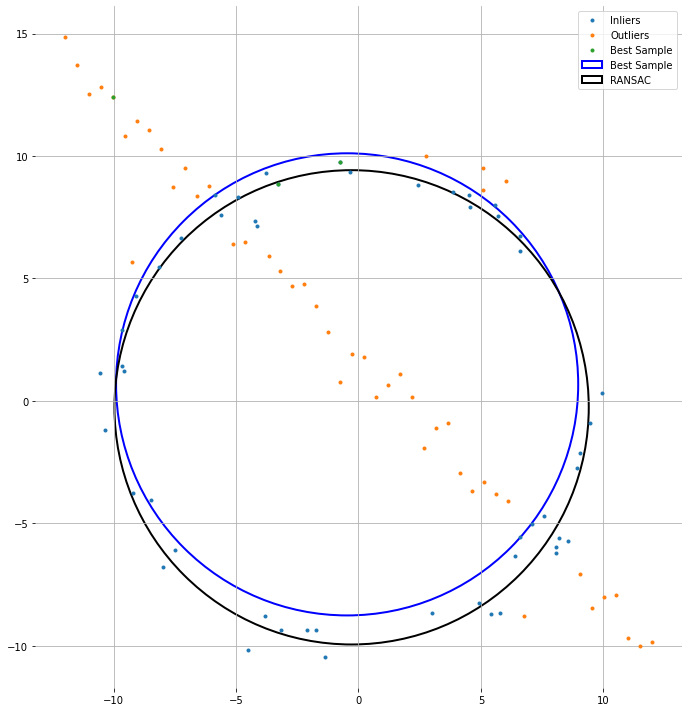

In [41]:
# Using Ransac to get the model
threshold = 1.1
ransac_run = Ransac(X,threshold,'circle')
inliers,outliers = ransac_run.get_inliers_outliers()
print(ransac_run,'\n')

circle,final_model,model_points = ransac_run.get_model()
# Verbose 

print('Final Model :\n',final_model)
visualize_points_and_circle([inliers,outliers,model_points],[[circle,'blue'],[final_model,'black']],legends=[["Inliers",'Outliers',"Best Sample"],['Best Sample','RANSAC']],grid=True)

### $Q_2$ : Super Impose Image

In [4]:
# Function to create overlay
def overlay_image(im_src,im_dst,pts_src,pts_dst):
    h = cv.getPerspectiveTransform(pts_src, pts_dst)
    transformed_image=cv.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
    b = (transformed_image[:,:,0]==0)*im_dst[:,:,0]
    g=(transformed_image[:,:,1]==0)*im_dst[:,:,1]
    r=(transformed_image[:,:,2]==0)*im_dst[:,:,2]
    masked=np.dstack((b,g,r))
    overlayed=cv.add(masked,transformed_image)
    return overlayed

# Importing Images
ice_age = cv.imread(r'./images/ice-age.webp')
virumandi = cv.imread(r'./images/virumandi.jpg')
image = cv.imread(r'./images/times_square_night.jpg')
assert ice_age is not None
assert virumandi is not None
assert image is not None

In [ ]:
# Function for getting co-ordinates by mouse click
def click_event(event,x,y,flags,params):
    if event==cv.EVENT_LBUTTONDOWN:
        print(x,' ',y)
        

# cv.imshow('image',image)
# cv.setMouseCallback('image',click_event)
# cv.waitKey(0)
# cv.destroyAllWindows()

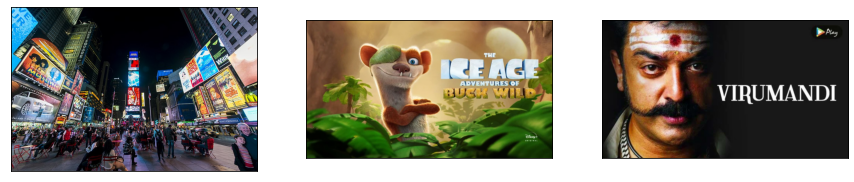

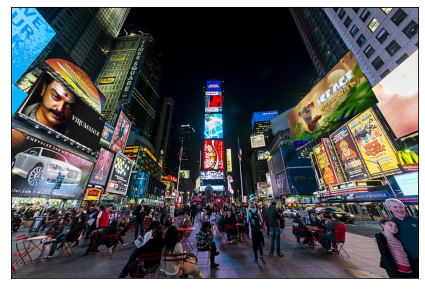

In [6]:
# Defining Points to find homography
iceAge_src = np.float32([[0, 0], [ice_age.shape[0], 0], [ice_age.shape[0], ice_age.shape[1]], [0, ice_age.shape[1]]])
ice_age_dst = np.float32([[540, 215], [593,160],[653,327],[573,344]])

virumandi_src = np.float32([[0, 0], [virumandi.shape[0], 0], [virumandi.shape[0], virumandi.shape[1]], [0, virumandi.shape[1]]])
virumandi_dst = np.float32([[68,128], [145,190],[90,330],[-35,295]])

final1 = overlay_image(ice_age,image,iceAge_src,ice_age_dst)
final2 = overlay_image(virumandi,final1,virumandi_src,virumandi_dst)
show_images([[image],[ice_age],[virumandi]],size=5)
show_images([[final2]],size=20)

### $Q_3$ : Image Stiching

In [8]:
# Extracting Co-ordinates of matching points using SIFT Operator
def points_extractor(image1,image2,verbose=False):
    sift = cv.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(image1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image2,None)

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors_1,descriptors_2, k=2)

    # Apply ratio test
    good = []

    for m,n in matches:
        if m.distance < .7*n.distance:
            good.append([m])

    matching_points = np.float32([[keypoints_1[mat[0].queryIdx].pt, keypoints_2[mat[0].trainIdx].pt]  for mat in good ])
    print("Number of Good Matches : ", len(good))

    if verbose:
        # Visualization
        image1_gray=cv.convert(image1,cv.COLOR_BGR2GRAY)
        image2_gray=cv.convert(image2,cv.COLOR_BGR2GRAY)
        f3 = cv.drawMatchesKnn(image1_gray,keypoints_1,image2_gray,keypoints_2,good,None)


        fig = plt.figure(figsize=(18, 6))
        plt.imshow(f3)
        plt.axis("off")
        plt.title("Visualizing Top Matches")
        plt.show()
    return matching_points
    

In [9]:
# Controlling Annoying Visulizations
verbose=False

# Reading All the Avialble Images
im1=cv.imread('./images/graffiti/img1.ppm',cv.IMREAD_COLOR)
im2=cv.imread('./images/graffiti/img2.ppm',cv.IMREAD_COLOR)
im3=cv.imread('./images/graffiti/img3.ppm',cv.IMREAD_COLOR)
im4=cv.imread('./images/graffiti/img4.ppm',cv.IMREAD_COLOR)
im5=cv.imread('./images/graffiti/img5.ppm',cv.IMREAD_COLOR)
im6=cv.imread('./images/graffiti/img6.ppm',cv.IMREAD_COLOR)
for image in [im1,im2,im3,im4,im5,im6]:
    assert image is not None

if verbose :
    show_images([[im1],[im2],[im3],[im4],[im5],[im6]])

In [10]:
m_1_2=points_extractor(im1,im2)
m_2_3=points_extractor(im2,im3)
m_3_4=points_extractor(im3,im4)
m_4_5=points_extractor(im4,im5)

Number of Good Matches :  1030
Number of Good Matches :  993
Number of Good Matches :  1170
Number of Good Matches :  934


RANSAC Transformation :
 0.594230	0.023356	227.644703 
0.215515	1.066196	-8.787754 
0.000475	-0.000151	1.000000 

Real Transformation :
 0.625446	0.057759	222.012170 
0.222405	1.165215	-25.605611 
0.000492	-0.000037	1.000000 



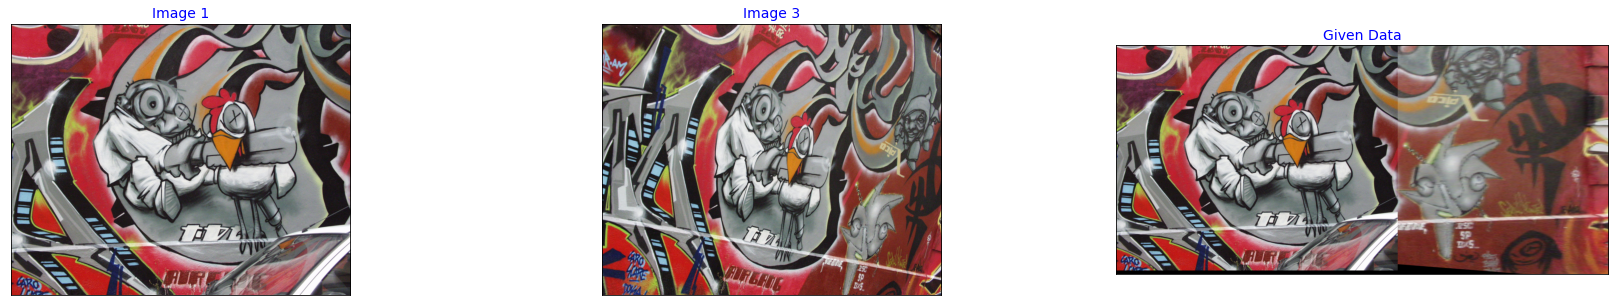

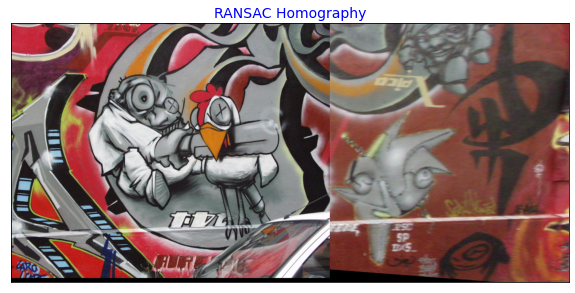

In [24]:

# Transforming Image 1 to 5 using Ransac
verbose=False
threshold = [138,135,150,130]
# Ransac Run
r_1_2 = Ransac(m_1_2,threshold[0],'homo')
r_2_3 = Ransac(m_2_3,threshold[1],'homo')
r_3_4 = Ransac(m_3_4,threshold[2],'homo')
r_4_5 = Ransac(m_4_5,threshold[3],'homo')

_,h_1_2,_ = r_1_2.get_model()
_,h_2_3,_ = r_2_3.get_model()
_,h_3_4,_ = r_3_4.get_model()
_,h_4_5,_ = r_4_5.get_model()



if verbose:
    print('RANSAC FITTING \n -------------\n')
    print('image1 ----> image2\n',r_1_2,'\n')
    print('image2 ----> image3\n',r_2_3,'\n')
    print('image3 ----> image4\n',r_3_4,'\n')
    print('image4 ----> image5\n',r_4_5,'\n')


h_1_5=Homography(h_4_5.H@h_3_4.H@h_2_3.H@h_1_2.H)

ransac_warped = cv.warpPerspective(im5 ,np.linalg.inv(h_1_5.H), (1400,650))
ransac_warped[0:im1.shape[0], 0:im1.shape[1]] = im1

# Original Transformation
with open("./images/graffiti/H1to5p", "r") as txt_file:
  f= txt_file.readlines()
h=[[float(x) for x in line.split()] for line in f]

r_t = Homography(h)


original_warped = cv.warpPerspective(im5, np.linalg.inv(r_t.H), (1400,650))
original_warped[0:im1.shape[0], 0:im1.shape[1]] = im1


print('RANSAC Transformation :\n',h_1_5,'\n')
print('Real Transformation :\n',r_t,'\n')
show_images([[im1,'c',"Image 1"],[im3,'c',"Image 3"],[original_warped,'c',"Given Data"]],size=10)
show_images([[ransac_warped,'c',"RANSAC Homography"]],size=10)